# <center>StudentPerforamnceRegressor  </center>
<img src= "https://blog.edmentum.com/sites/blog.edmentum.com/files/styles/blog_image/public/images/MeasuringStudentGrowth.png?itok=dm-KlP3N" height="200" align="center"/>

<a id="Table-Of-Contents"></a>
# Table Of Contents
* [Table Of Contents](#Table-Of-Contents)
* [Importing Libraries](#Importing-Libraries)
* [Task Details](#Task-Details)
* [Feature Description](#Feature-Description)
* [Read in Data](#Read-in-Data)
    - [StudentsPerformance.csv](#StudentsPerformance.csv)
* [Data Visualization](#Data-Visualization)
    - [Features Visualizaiton](#Features-Visualizaiton)
    - [Target Visualizaiton](#Target-Visualizaiton)
* [Preprocessing Data](#Preprocessing-Data)
    - [Removing Outliers](#Removing-Outliers)
    - [Label Encoding](#Label-Encoding)
    - [Dummy Encoding](#Dummy-Encoding)
    - [Train-Test Split](#Train-Test-Split)
* [Initial Models](#Initial-Models)
* [LightGBM Regressor](#LightGBM-Regressor)
    - [Bayesian Optimization](#Bayesian-Optimization)
    - [Tuning LightGBM](#Tuning-LightGBM)
    - [Feature Importance](#Feature-Importance)
    - [Model Performance](#Model-Performance)
* [Conclusion](#Conclusion)

<a id="Importing-Libraries"></a>
# Importing Libraries

In [1]:
#%% Imports

# Basic Imports 
import numpy as np
import pandas as pd

# Plotting 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

# Preprocessing
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder

# Metrics 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ML Models
import lightgbm as lgb
from lightgbm import LGBMRegressor 
import xgboost as xg 
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.linear_model import LinearRegression
# Model Tuning 
from bayes_opt import BayesianOptimization

# Feature Importance 
import shap

# Ignore Warnings 
import warnings
warnings.filterwarnings('ignore')

<a id="Task-Details"></a>
# Task Detail 

Predicting student performance with the demographic and socioeconomic information.

## Expected Submission
The solution should contain Notebook with prediction accuracy.
An informative solution should also include statistical testing and information about what contributes the prediction.
Of course the script should be easy to read and understand.

## Evaluation
I will use various prediction accuarcy such as RMSE, MSE and MSAE

<a id="Feature-Description"></a>
# Feature Description 

## Target  
* math score
* reading score
* writing score
* average score (average of math, reading and writing score)

## Features
* gender
* race/ethnicity
* parental level of education
* lunch
* test preparation course

<a id="Read-in-Data"></a>
# Read in Data

<a id="StudentsPerformance.csv"></a>
## StudentsPerformance.csv

In [2]:
#%% Read StudentsPerformance.csv
SP_csv = pd.read_csv("../input/students-performance-in-exams/StudentsPerformance.csv")
SP_csv['average score'] = SP_csv[['math score', 'reading score','writing score']].mean(axis=1)
# Initial glance at StudentsPerformance.csv
print(SP_csv.info(verbose = True,null_counts=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math score                   1000 non-null   int64  
 6   reading score                1000 non-null   int64  
 7   writing score                1000 non-null   int64  
 8   average score                1000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB
None


<a id="Data-Visualization "></a>
# Data Visualization 


<a id="Features-Visualizaiton"></a>
## Features Visualizaiton

In [3]:
#%% PlotMultiplePie 
# Input: df = Pandas dataframe, categorical_features = list of features , dropna = boolean variable to use NaN or not
# Output: prints multiple px.pie() 

def PlotMultiplePie(df,categorical_features = None,dropna = False):
    # set a threshold of 30 unique variables, more than 50 can lead to ugly pie charts 
    threshold = 30
    
    # if user did not set categorical_features 
    if categorical_features == None: 
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
        
    print("The Categorical Features are:",categorical_features)
    
    # loop through the list of categorical_features 
    for cat_feature in categorical_features: 
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        # prints pie chart and info if unique values below threshold 
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature, 
                 names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
            fig.show()
        else: 
            print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')

In [4]:
#%% Use PlotMultiplePie to see the distribution of the categorical variables 
PlotMultiplePie(SP_csv)

The Categorical Features are: ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']
Pie Chart for:  gender
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  race/ethnicity
Number of Unique Values:  5
Number of Missing Values:  0


Pie Chart for:  parental level of education
Number of Unique Values:  6
Number of Missing Values:  0


Pie Chart for:  lunch
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  test preparation course
Number of Unique Values:  2
Number of Missing Values:  0


<a id="Target-Visualization "></a>
## Target Visualization 

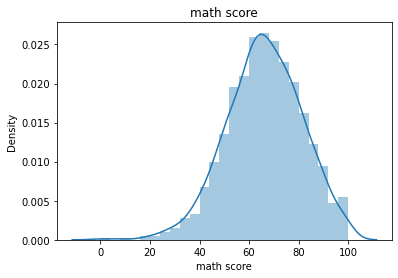

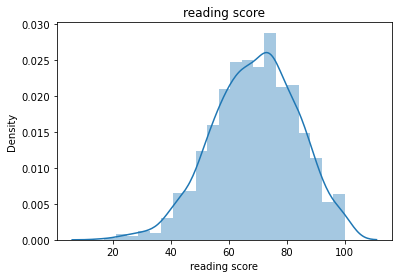

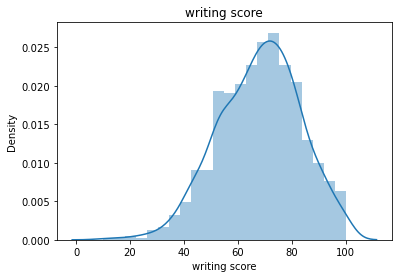

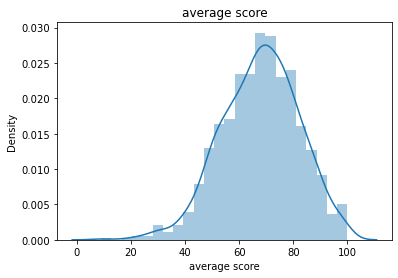

In [5]:
#%% Print the continous features in the dataset 
continous_features = SP_csv.select_dtypes(['float64','int64']).columns.to_list()

for cont_feature in continous_features: 
    plt.figure()
    plt.title(cont_feature)
    ax = sns.distplot(SP_csv[cont_feature])

<a id="Preprocessing-Data"></a>
# Preprocessing Data

## Removing Outliers
Outliers can be removed to obtain a better model. Due to this dataset having only 1000 observations, it might not be useful here. I left this section for anyone who needs to remove outliers from their dataset.

In [6]:
#%% Remove outliers below lower% and above upper % quantile
# https://nextjournal.com/schmudde/how-to-remove-outliers-in-data
def remove_outliers(df,column_name,lower,upper):
    removed_outliers = df[column_name].between(df[column_name].quantile(lower), df[column_name].quantile(upper))
    
    print(str(df[column_name][removed_outliers].size) + "/" + str(SP_csv[column_name].size) + " data points remain.") 

    index_names = df[~removed_outliers].index # INVERT removed_outliers!!
    return df.drop(index_names)

# SP_csv_clean = remove_outliers(sp_csv_clean,"average score",0.05,0.95)

In [7]:
# Seperate features and target 
SP_csv_clean = SP_csv.copy()
math_score = SP_csv_clean["math score"]
reading_score = SP_csv_clean["reading score"]
writing_score = SP_csv_clean["writing score"]
average_score = SP_csv_clean["average score"]
X_features = SP_csv_clean.drop(["math score","reading score","writing score","average score"],axis = 'columns') 

<a id="Label-Encoding"></a>
# Label Encoding

In [8]:
#%% MultiColumnLabelEncoder
# Code snipet found on Stack Exchange 
# https://stackoverflow.com/questions/24458645/label-encoding-across-multiple-columns-in-scikit-learn
from sklearn.preprocessing import LabelEncoder


class MultiColumnLabelEncoder:
    def __init__(self,columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                # convert float NaN --> string NaN
                output[col] = output[col].fillna('NaN')
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

# # store the catagorical features names as a list      
# cat_features = X_features.select_dtypes(['object']).columns.to_list()

# # use MultiColumnLabelEncoder to apply LabelEncoding on cat_features 
# # uses NaN as a value , no imputation will be used for missing data
# X_features_encoded = MultiColumnLabelEncoder(columns = cat_features).fit_transform(X_features)

## Manual Encoding

In [9]:
##% Manual Encoding 
# X_features_encoded = X_features_clean.copy() 
# print(X_features_encoded.columns)
# print(X_features["race/ethnicity"].value_counts())

# def encode_parent_education(string):
#     if string == "some high school":
#         return 0 
#     elif string == "high school":
#         return 1 
#     elif string == "some college":
#         return 2 
#     elif string == "associate's degree":
#         return 3 
#     elif string == "bachelor's degree":
#         return 4 
#     elif string == "master's degree":
#         return 5 
#     else:
#         return None

# def encode_race_ethnicity(string):
#     if string == "group A":
#         return 0 
#     elif string == "group B":
#         return 1 
#     elif string == "group C":
#         return 2 
#     elif string == "group D":
#         return 3 
#     elif string == "group E":
#         return 4 
#     else:
#         return None

# X_features_encoded["parental level of education"] = [encode_parent_education(x) for x in X_features_encoded["parental level of education"]]
# X_features_encoded["race/ethnicity"] = [encode_race_ethnicity(x) for x in X_features_encoded["race/ethnicity"]]
# X_features_encoded['gender'] = [0 if x == "female" else 1 for x in  X_features_encoded['gender']]
# X_features_encoded['test preparation course'] = [0 if x == "none" else 1 for x in  X_features_encoded['test preparation course']]
# X_features_encoded['lunch'] = [0 if x == "standard" else 1 for x in  X_features_encoded['lunch']]

## Dummy Encoding

In [10]:
##% Dummy Encoding
# https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a

# convert all features to categorical data type 
X_features_encoded = X_features.apply(lambda x: x.astype('category')) 
# get dummies for all features but remove the first one(avoid multicollinearity) also called Dummy Variable Trap
X_features_encoded = pd.get_dummies(X_features_encoded,drop_first= True)

In [11]:
##% Before and After LabelEncoding for train.csv 
display(X_features)
display(X_features_encoded)

,gender,race/ethnicity,parental level of education,lunch,test preparation course
0,female,group B,bachelor's degree,standard,none
1,female,group C,some college,standard,completed
2,female,group B,master's degree,standard,none
3,male,group A,associate's degree,free/reduced,none
4,male,group C,some college,standard,none
...,...,...,...,...,...
995,female,group E,master's degree,standard,completed
996,male,group C,high school,free/reduced,none
997,female,group C,high school,free/reduced,completed
998,female,group D,some college,standard,completed


,gender_male,race/ethnicity_group B,race/ethnicity_group C,race/ethnicity_group D,race/ethnicity_group E,parental level of education_bachelor's degree,parental level of education_high school,parental level of education_master's degree,parental level of education_some college,parental level of education_some high school,lunch_standard,test preparation course_none
0,0,1,0,0,0,1,0,0,0,0,1,1
1,0,0,1,0,0,0,0,0,1,0,1,0
2,0,1,0,0,0,0,0,1,0,0,1,1
3,1,0,0,0,0,0,0,0,0,0,0,1
4,1,0,1,0,0,0,0,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,1,0,0,1,0,0,1,0
996,1,0,1,0,0,0,1,0,0,0,0,1
997,0,0,1,0,0,0,1,0,0,0,0,0
998,0,0,0,1,0,0,0,0,1,0,1,0


<a id="#Train-Test-Split"></a>
# Train-Test Split

In [12]:
# Create test and train set 80-20
#%%  train-test split using a 80-20 split
target = average_score
train_X, valid_X, train_y, valid_y = train_test_split(X_features_encoded, target, test_size=0.2, shuffle = True, random_state=1)

# Initial Models
We can apply different machine learning algorthims to test which model perform better on this dataset. I've listed below various machine learning techniques applied in this section.
 
1. RandomForest
2. Support Vector Machine
3. XGBoost
4. LightGBM
5. Linear Regression

In [13]:
##% evaluateRegressor
# https://towardsdatascience.com/what-are-the-best-metrics-to-evaluate-your-regression-model-418ca481755b
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_scor
def evaluateRegressor(true,predicted,message = "Test set"):
    MSE = mean_squared_error(true,predicted,squared = True)
    MAE = mean_absolute_error(true,predicted)
    RMSE = mean_squared_error(true,predicted,squared = False)
    R_squared = r2_score(true,predicted)
    print(message)
    print("MSE:", MSE)
    print("MAE:", MAE)
    print("RMSE:", RMSE)
    print("R-squared:", R_squared)

In [14]:
##% Plot True vs predicted values. Useful for continuous y 
def PlotPrediction(true,predicted, title = "Dataset: "):
    fig = plt.figure(figsize=(20,20))
    ax1 = fig.add_subplot(111)
    ax1.set_title(title + 'True vs Predicted')
    ax1.scatter(list(range(0,len(true))),true, s=10, c='r', marker="o", label='True')
    ax1.scatter(list(range(0,len(predicted))), predicted, s=10, c='b', marker="o", label='Predicted')
    plt.legend(loc='upper right');
    plt.show()

In [15]:
##% Initial Models
# from sklearn.ensemble import RandomForestRegressor
# from sklearn import svm
# import lightgbm as lgb
# import xgboost as xg 

RFReg = RandomForestRegressor(random_state = 0).fit(train_X, train_y)
SVM = svm.SVR().fit(train_X, train_y) 
XGReg = xg.XGBRegressor(objective ='reg:squarederror', seed = 1,verbosity=0).fit(train_X,train_y) 
LGBMReg = lgb.LGBMRegressor(random_state=0).fit(train_X,train_y)
LinearReg = LinearRegression(normalize = True).fit(train_X,train_y)

In [16]:
##% Model Metrics
print("Random Forest Regressor") 
predicted_train_y = RFReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = RFReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")
    
print("Support Vector Machine") 
predicted_train_y = SVM.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = SVM.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")


print("XGBoost Regressor") 
predicted_train_y = XGReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = XGReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")

print("LightGBM Regressor") 
predicted_train_y = LGBMReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LGBMReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")

print("Linear Regression") 
predicted_train_y = LinearReg.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
predicted_valid_y = LinearReg.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
print("\n")

Random Forest Regressor
    Training Set
MSE: 124.18248881828876
MAE: 8.875503411746514
RMSE: 11.143719702966724
R-squared: 0.3818673819971736
    Test Set
MSE: 195.79915483205085
MAE: 10.979411742076943
RMSE: 13.992825119755155
R-squared: 0.0744194291616822


Support Vector Machine
    Training Set
MSE: 159.64489171170692
MAE: 10.009269614551227
RMSE: 12.635065955969795
R-squared: 0.20534919372624194
    Test Set
MSE: 171.64537907831914
MAE: 10.414987967935296
RMSE: 13.101350276911122
R-squared: 0.1885990106272717


XGBoost Regressor
    Training Set
MSE: 123.29833843394681
MAE: 8.738982764879863
RMSE: 11.103978495744073
R-squared: 0.38626834220486606
    Test Set
MSE: 201.53085900578054
MAE: 11.210218467712401
RMSE: 14.19615648708412
R-squared: 0.04732455214064668


LightGBM Regressor
    Training Set
MSE: 135.10494155889103
MAE: 9.357950654724123
RMSE: 11.623465127013159
R-squared: 0.32749961749343715
    Test Set
MSE: 173.7125646697983
MAE: 10.26485646038186
RMSE: 13.18000624695596

<a id="LightGBM-Regressor"></a>
# LightGBM Regressor

In [17]:
##% parameter tuning for lightgbm 
# store the catagorical features names as a list      
cat_features = train_X.select_dtypes(['int64']).columns.to_list()

# Create the LightGBM data containers
# Make sure that cat_features are used
train_data=lgb.Dataset(train_X,label=train_y, categorical_feature = cat_features,free_raw_data=False)
valid_data=lgb.Dataset(valid_X,label=valid_y, categorical_feature = cat_features,free_raw_data=False)

## Bayesian Optimization

In [18]:
# https://medium.com/analytics-vidhya/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9
# from lightgbm import LGBMRegressor 
# from bayes_opt import BayesianOptimization
def search_best_param(X,y,cat_features):
    
    trainXY = lgb.Dataset(data=X, label=y,categorical_feature = cat_features,free_raw_data=False)
    # define the lightGBM cross validation
    def lightGBM_CV(max_depth, num_leaves, n_estimators, learning_rate, subsample, colsample_bytree, 
                lambda_l1, lambda_l2, min_child_weight):
    
        params = {'boosting_type': 'gbdt', 'objective': 'regression', 'metric':'rmse', 'verbose': -1,
                  'early_stopping_round':100}
        
        params['max_depth'] = int(round(max_depth))
        params["num_leaves"] = int(round(num_leaves))
        params["n_estimators"] = int(round(n_estimators))
        params['learning_rate'] = learning_rate
        params['subsample'] = subsample
        params['colsample_bytree'] = colsample_bytree
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_child_weight'] = min_child_weight
    
        score = lgb.cv(params, trainXY, nfold=5, seed=1, stratified=False, verbose_eval =False, metrics=['rmse'])

        return -np.min(score['rmse-mean']) # min or max can change best_param

    # use bayesian optimization to search for the best hyper-parameter combination
    lightGBM_Bo = BayesianOptimization(lightGBM_CV, 
                                       {
                                          'max_depth': (5, 50),
                                          'num_leaves': (20, 100),
                                          'n_estimators': (50, 1000),
                                          'learning_rate': (0.01, 0.3),
                                          'subsample': (0.7, 0.8),
                                          'colsample_bytree' :(0.5, 0.99),
                                          'lambda_l1': (0, 5),
                                          'lambda_l2': (0, 3),
                                          'min_child_weight': (2, 50) 
                                      },
                                       random_state = 1,
                                       verbose = 0
                                      )
    np.random.seed(1)
    
    lightGBM_Bo.maximize(init_points=5, n_iter=15) # 20 combinations 
    
    params_set = lightGBM_Bo.max['params']
    
    # get the params of the maximum target     
    max_target = -np.inf
    for i in lightGBM_Bo.res: # loop thru all the residuals 
        if i['target'] > max_target:
            params_set = i['params']
            max_target = i['target']
    
    params_set.update({'verbose': -1})
    params_set.update({'metric': 'rmse'})
    params_set.update({'boosting_type': 'gbdt'})
    params_set.update({'objective': 'regression'})
    
    params_set['max_depth'] = int(round(params_set['max_depth']))
    params_set['num_leaves'] = int(round(params_set['num_leaves']))
    params_set['n_estimators'] = int(round(params_set['n_estimators']))
    params_set['seed'] = 1 #set seed
    
    return params_set

best_params = search_best_param(train_X,train_y,cat_features)

In [19]:
# Print best_params
for key, value in best_params.items():
    print(key, ' : ', value)

colsample_bytree  :  0.5720833772911492
lambda_l1  :  0.4987474663840836
lambda_l2  :  2.8392612965253683
learning_rate  :  0.3
max_depth  :  17
min_child_weight  :  33.33494716294979
n_estimators  :  877
num_leaves  :  87
subsample  :  0.7
verbose  :  -1
metric  :  rmse
boosting_type  :  gbdt
objective  :  regression
seed  :  1


<a id="Tuning-LightGBM"></a>
## Tuning LightGBM

In [20]:
# Train lgbm_best using the best params found from Bayesian Optimization
lgbm_best = lgb.train(best_params,
                 train_data,
                 num_boost_round = 2500,
                 valid_sets = valid_data,
                 early_stopping_rounds = 200,
                 verbose_eval = 100
                 )

Training until validation scores don't improve for 200 rounds
[100]	valid_0's rmse: 12.7606
[200]	valid_0's rmse: 12.9057
Early stopping, best iteration is:
[24]	valid_0's rmse: 12.5531


<a id="Feature-Importance "></a>
## Feature Importance 

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

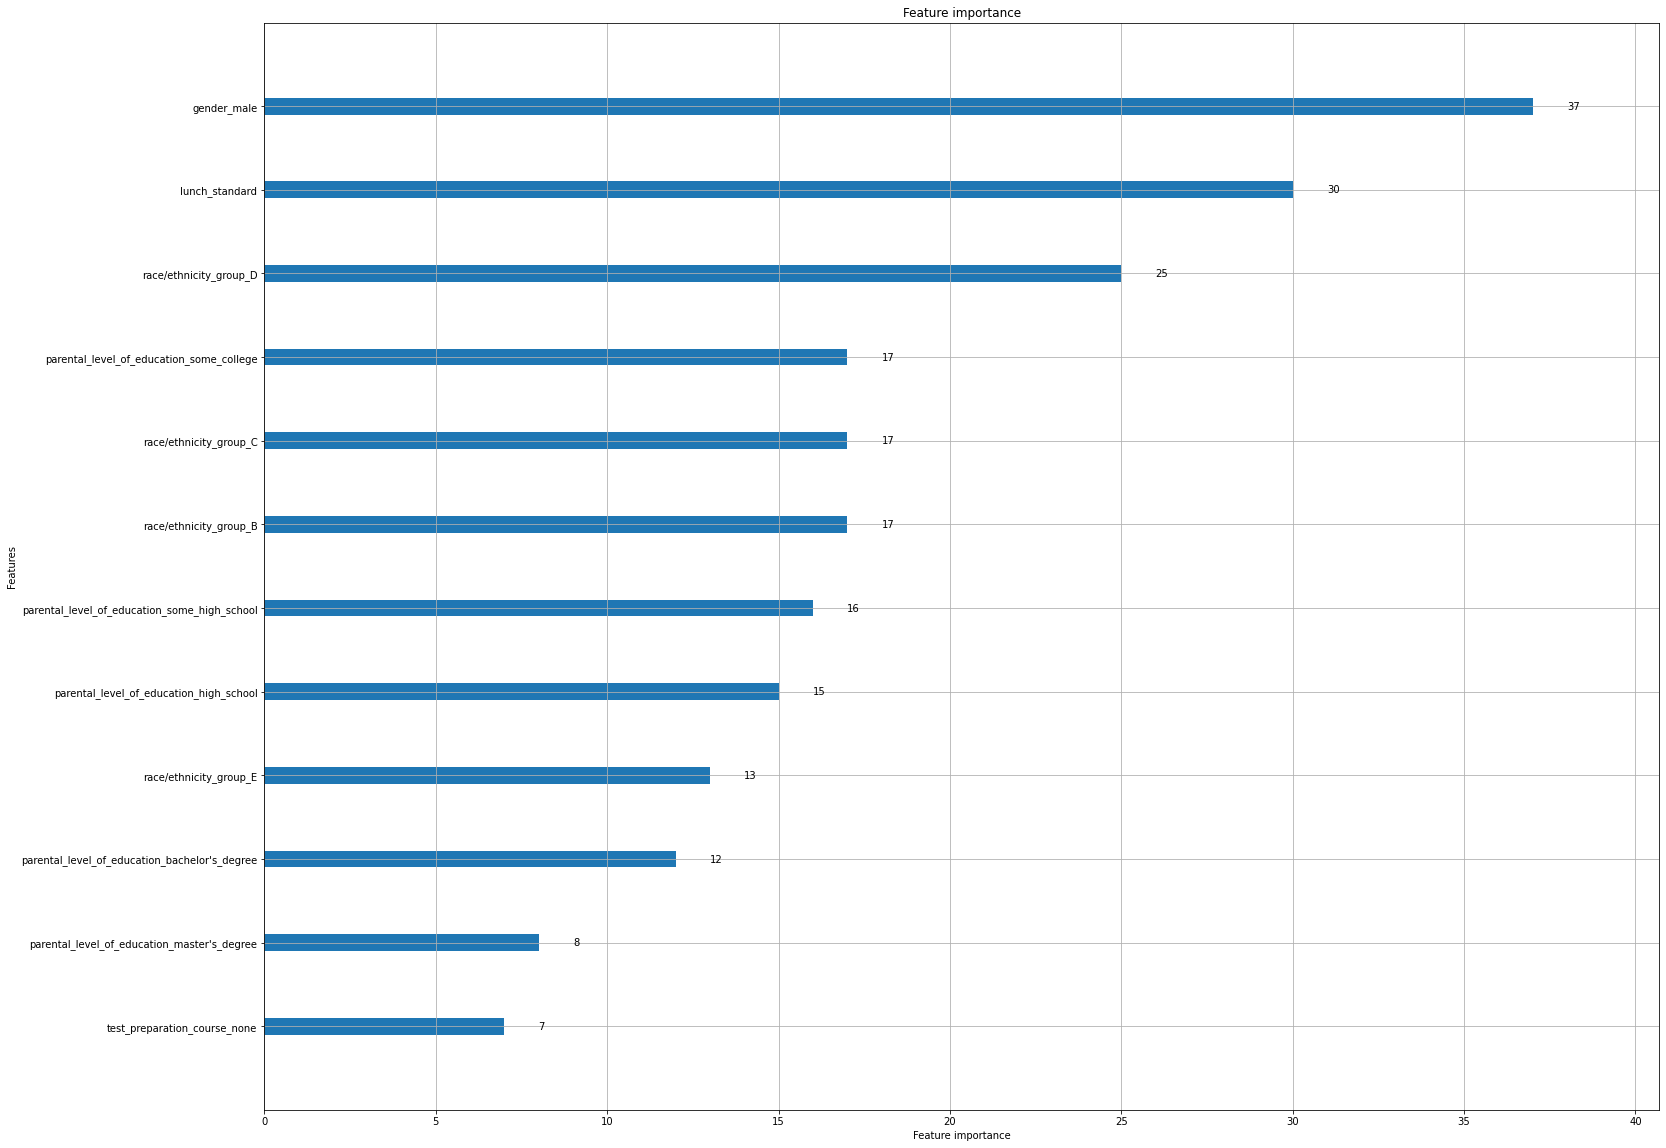

In [21]:
##% Feature Importance 
# https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
lgb.plot_importance(lgbm_best,figsize=(25,20))

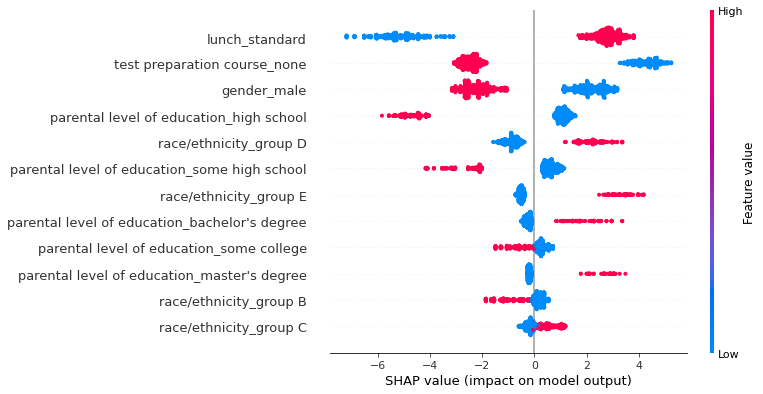

In [22]:
##% Feature Importance using shap package 
# import shap
lgbm_best.params['objective'] = 'regression'
shap_values = shap.TreeExplainer(lgbm_best).shap_values(train_X)
shap.summary_plot(shap_values, train_X)

From both feature importance, we can see that **lunch**, **test preparation course**, and **gender** contributes a lot in prediction of a student performance. The shap package is prefer when finding feature importance as it preservces consistency and accuracy. You can read more about the shap package in the links provided below:

[https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html](https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.html)

[https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d](https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d)  

[https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27](https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27)

<a id="Model-Performance"></a>
## Model Performance

    Training Set
MSE: 148.58710412552873
MAE: 9.858675737695574
RMSE: 12.189631008587943
R-squared: 0.2603906029861668


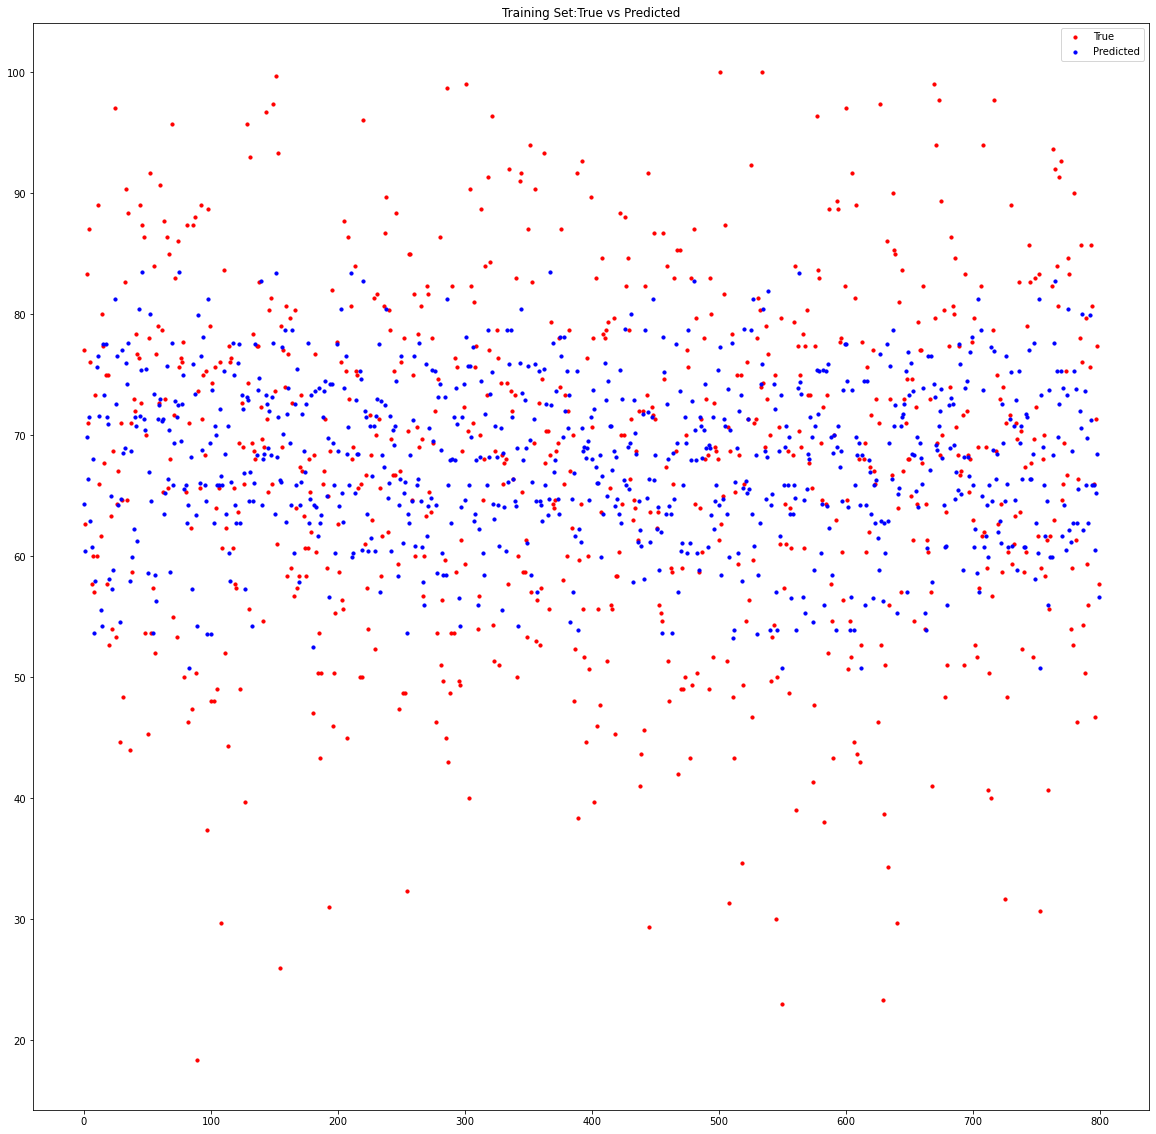

In [23]:
predicted_train_y = lgbm_best.predict(train_X)
evaluateRegressor(train_y,predicted_train_y,"    Training Set")
PlotPrediction(train_y,predicted_train_y, "Training Set:")

    Test Set
MSE: 157.5806399696469
MAE: 9.894307861045238
RMSE: 12.553112760174145
R-squared: 0.25508575958215485


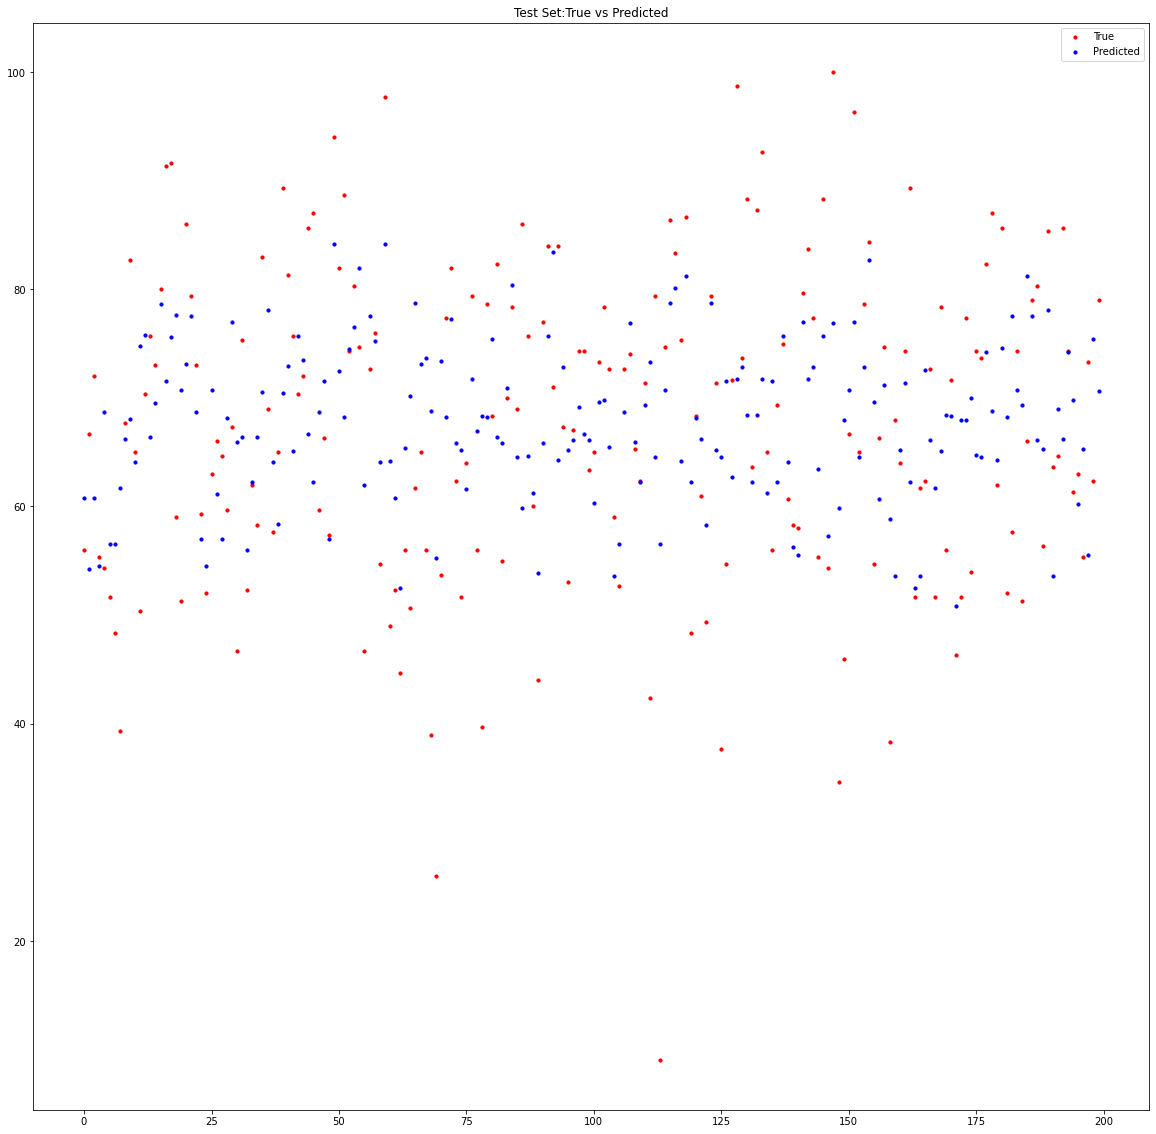

In [24]:
predicted_valid_y = lgbm_best.predict(valid_X)
evaluateRegressor(valid_y,predicted_valid_y,"    Test Set")
PlotPrediction(valid_y,predicted_valid_y, "Test Set:")

    Entire Set
MSE: 150.38581129435238
MAE: 9.865802162365508
RMSE: 12.263189279072241
R-squared: 0.2594315336973835


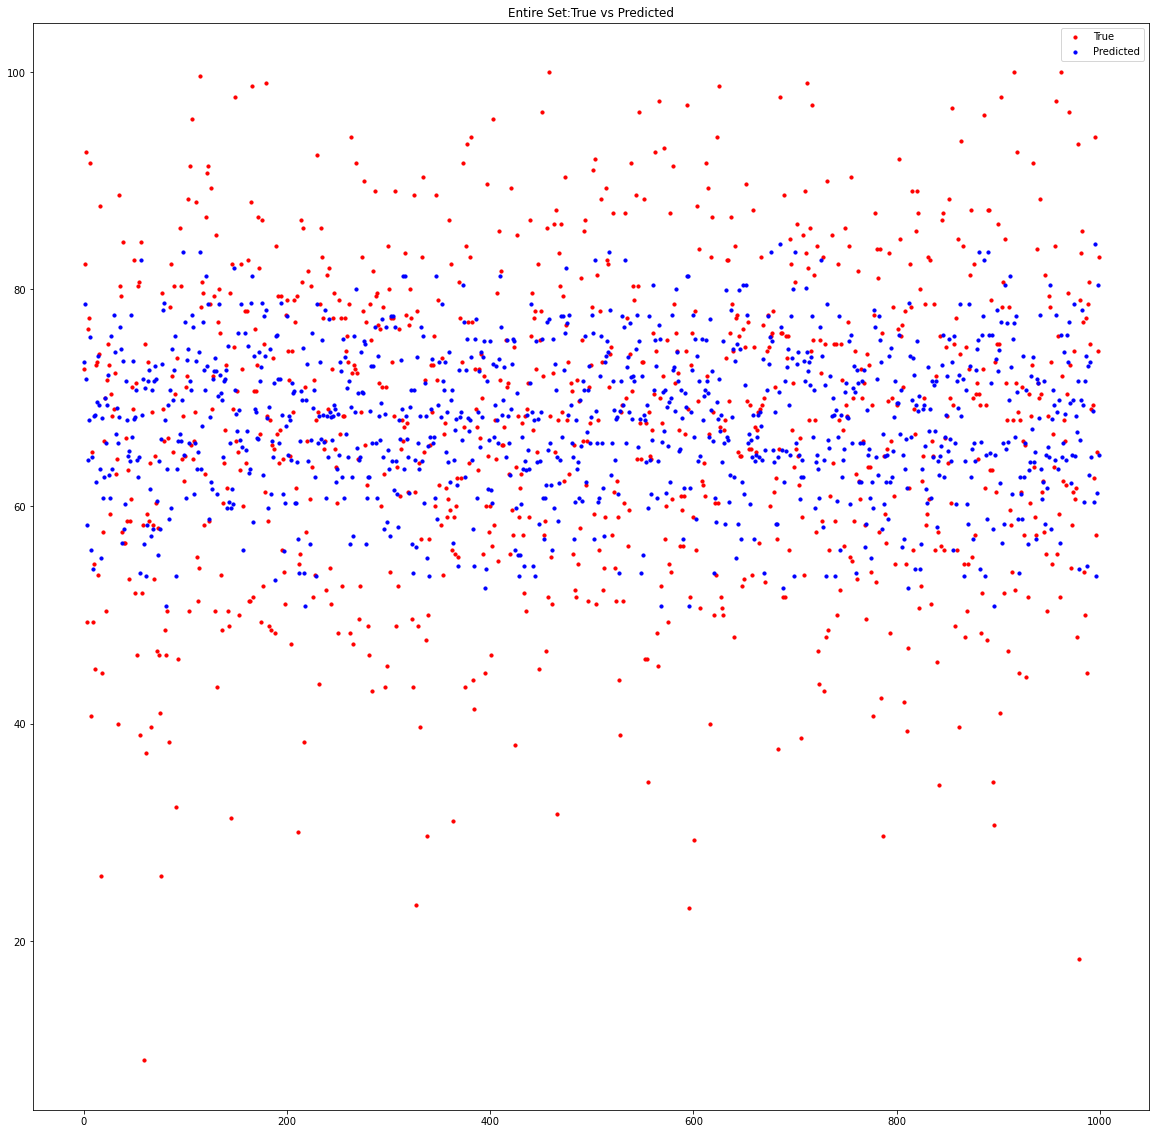

In [25]:
predicted_entire_y = lgbm_best.predict(X_features_encoded)
evaluateRegressor(target,predicted_entire_y,"    Entire Set")
PlotPrediction(target,predicted_entire_y, "Entire Set:")

<a id="Conclusion"></a>
# Conclusion

**Conclusion**
* This dataset was easy to work with due to having few features and observations  
* Learnt a lot about using different encoding methods on categorical data

**Challenges**
* The models perform poorly due to have few features. It was difficult to predict low or high scores

**Closing Remarks**  
* Please comment and like the notebook if it of use to you! Have a wonderful year! 

**Other Notebooks** 
* [https://www.kaggle.com/josephchan524/hranalytics-lightgbm-classifier-auc-80](https://www.kaggle.com/josephchan524/hranalytics-lightgbm-classifier-auc-80)
* [https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95](https://www.kaggle.com/josephchan524/bankchurnersclassifier-recall-97-accuracy-95)
* [https://www.kaggle.com/josephchan524/housepricesregressor-using-lightgbm](https://www.kaggle.com/josephchan524/housepricesregressor-using-lightgbm)
* [https://www.kaggle.com/josephchan524/tabularplaygroundregressor-using-lightgbm-feb2021](https://www.kaggle.com/josephchan524/tabularplaygroundregressor-using-lightgbm-feb2021)

2-12-2020
Joseph Chan 